In [47]:
# Some portions of this code is attributed from 
# https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch as t
import cv2
import matplotlib.pyplot as plt
import sys
import time
import os
from PIL import Image
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
from multiprocessing import cpu_count

import torch.optim as optim
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.utils.data import DataLoader

LEARNING_RATE = 1e-3
DEVICE = "cuda" if t.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS = min(4, cpu_count() - 1)
IMAGE_HEIGHT = 512 # 1512 originally
IMAGE_WIDTH = 512 # 2016 originally
TARGET_SIZE = 512
NUM_CLASSES = 15
VISUALIZE = True
class_color_map = {
    0: [60,180,75],
    1: [145,30,180],
    2: [255,225,25],
    3: [70,240,240],
    4: [0,0,0],
    5: [230,25,75],
    6: [128,128,128],
    7: [128,128,0],
    8: [210,245,60],
    9: [240,50,230],
    10: [0,128,128],
    11: [250,190,190],
    12: [170,255,195],
    13: [0,130,200],
    14: [0,0,128]
}

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


if t.cuda.is_available():
  print('PyTorch can use GPUs!')
else:
  print('PyTorch cannot use GPUs.')


PyTorch can use GPUs!


In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3,1,1, bias=False),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(out_channels, out_channels, 3,1,1, bias=False),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(inplace=True)
                                 )
    def forward(self, x):
        return self.conv(x)

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        # Downsampling into UNet
        for f in features:
            self.downs.append(DoubleConv(in_channels, f))
            in_channels = f
            
        # Upsampling, start from the bottom of the U
        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(in_channels=f*2, out_channels=f, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(f*2,f))
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            # Add skip connections to input convs. Do it for every layer
            # Highest resolution first, lowest last
            skip_connections.append(x)
            x = self.pool(x)
        # Double conv at very bottom. The bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Up, double conv
        for idx in range(0, len(self.ups), 2):
            #Conv transpose 2d
            x = self.ups[idx](x)
            skip_con = skip_connections[idx//2]
            # for when input is not divisible by 2. Not a multipel of 16
            # padding
            if x.shape != skip_con.shape:
                diff_h = skip_con.shape[2] - x.shape[2]
                diff_w = skip_con.shape[3] - x.shape[3]
                x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2])
            # Concatenate skips
            cat_skip = t.cat((skip_con,x), dim=1)
            x = self.ups[idx+1](cat_skip)
            
        return self.final_conv(x)

In [4]:
# Check if I built the model output correctly
def test_if_good():
    x = t.randn(size=(3,1,161,161))
    model = UNet(in_channels=1, out_channels=1)
    predictions = model(x)
    print(predictions.shape == x.shape)
test_if_good()
    

True


# Assemble Dataset

In [5]:
class WildScenesDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"), dtype=np.float32)
        
        # Map mask colors to class indices
        mask = self.mask_to_class_indices(mask)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

    def mask_to_class_indices(self, mask):
        # Initialize a 2D array for class indices
        class_indices = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
        
        # Reshape mask to a 2D array of RGB tuples
        reshaped_mask = mask.reshape(-1, 3)
        
        # Convert mask colors to class indices
        for class_idx, color in class_color_map.items():
            matches = np.all(reshaped_mask == color, axis=1)
            class_indices.reshape(-1)[matches] = class_idx
        
        return class_indices


# Train val test split

In [6]:
import os
import random
import shutil
from pathlib import Path


# Parameters
IMG_DIR = "/kaggle/input/wildscenes-1/data/WildScenes/WildScenes2d/V-01/image"
LABEL_DIR = "/kaggle/input/wildscenes-1/data/WildScenes/WildScenes2d/V-01/label"
OUTPUT_DIR = "/kaggle/working/"

train_ratio = 0.7  # Proportion of data for training
val_ratio = 0.2  # Proportion of data for validation (test is 1 - train - val)
seed = 42  # For reproducibility
if not os.path.exists("/kaggle/working/train/img"):
    
    # Set random seed
    random.seed(seed)
    
    # Create output directories for train/val/test with img/ and label/
    splits = ['train', 'val', 'test']
    subdirs = ['img', 'label']
    
    for split in splits:
        for subdir in subdirs:
            split_dir = Path(OUTPUT_DIR) / split / subdir
            split_dir.mkdir(parents=True, exist_ok=True)
    
    # Get all image files and match them to labels
    image_files = [f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))]
    image_files.sort()  # Ensure consistent ordering
    label_files = [f for f in os.listdir(LABEL_DIR) if os.path.isfile(os.path.join(LABEL_DIR, f))]
    label_files.sort()  # Ensure consistent ordering
    
    
    # Shuffle and split
    paired_files = list(zip(image_files, label_files))
    random.shuffle(paired_files)
    
    total_files = len(paired_files)
    train_end = int(total_files * train_ratio)
    val_end = train_end + int(total_files * val_ratio)
    
    train_files = paired_files[:train_end]
    val_files = paired_files[train_end:val_end]
    test_files = paired_files[val_end:]
    
    # Function to move files
    def copy_files(pairs, split):
        for img_file, lbl_file in pairs:
            img_src = os.path.join(IMG_DIR, img_file)
            lbl_src = os.path.join(LABEL_DIR, lbl_file)
            
            img_dst = Path(OUTPUT_DIR) / split / 'img' / img_file
            lbl_dst = Path(OUTPUT_DIR) / split / 'label' / lbl_file
            
            shutil.copy(img_src, img_dst)
            shutil.copy(lbl_src, lbl_dst)
    
    # Move files to respective directories
    copy_files(train_files, 'train')
    copy_files(val_files, 'val')
    copy_files(test_files, 'test')
    
    print("Image and label dataset has been split into train/val/test successfully.")
else:
    print("No need to move dataset into t/v/t")


No need to move dataset into t/v/t


In [7]:
!tree -L 2

.
|-- saved_images
|-- test
|   |-- img
|   `-- label
|-- train
|   |-- img
|   `-- label
`-- val
    |-- img
    `-- label

10 directories, 0 files


# Dataloaders

In [8]:
BASE_DIR = "/kaggle/working/"
TYPE_DIR = ["train","val","test"]
IMG_OR_LABEL = ["img","label"]


TRAIN_IMG = os.path.join(BASE_DIR,TYPE_DIR[0],IMG_OR_LABEL[0])
VAL_IMG = os.path.join(BASE_DIR,TYPE_DIR[1],IMG_OR_LABEL[0])
TEST_IMG = os.path.join(BASE_DIR,TYPE_DIR[2],IMG_OR_LABEL[0])

TRAIN_LABEL = os.path.join(BASE_DIR,TYPE_DIR[0],IMG_OR_LABEL[1])
VAL_LABEL = os.path.join(BASE_DIR,TYPE_DIR[1],IMG_OR_LABEL[1])
TEST_LABEL = os.path.join(BASE_DIR,TYPE_DIR[2],IMG_OR_LABEL[1])

train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=[0.0, 0.0, 0.0],std=[1.0, 1.0, 1.0],max_pixel_value=255.0),
    A.PadIfNeeded(min_height=TARGET_SIZE, min_width=TARGET_SIZE),
    ToTensorV2(),
])

val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(mean=[0.0, 0.0, 0.0],std=[1.0, 1.0, 1.0],max_pixel_value=255.0),
            A.PadIfNeeded(min_height=TARGET_SIZE, min_width=TARGET_SIZE),
            ToTensorV2()
])

train_ds = WildScenesDataset(image_dir=TRAIN_IMG, mask_dir=TRAIN_LABEL,transform=train_transform)
val_ds = WildScenesDataset(image_dir=VAL_IMG, mask_dir=VAL_IMG,transform=val_transform)
test_ds = WildScenesDataset(image_dir=TEST_IMG, mask_dir=TEST_IMG,transform=train_transform)

train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,pin_memory=True,shuffle=True)
val_loader = DataLoader(val_ds,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,pin_memory=True,shuffle=True)
test_loader = DataLoader(test_ds,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,pin_memory=True,shuffle=True)



# Visualize Dataset

Visualizing Training Data:   0%|          | 0/33 [00:00<?, ?it/s]

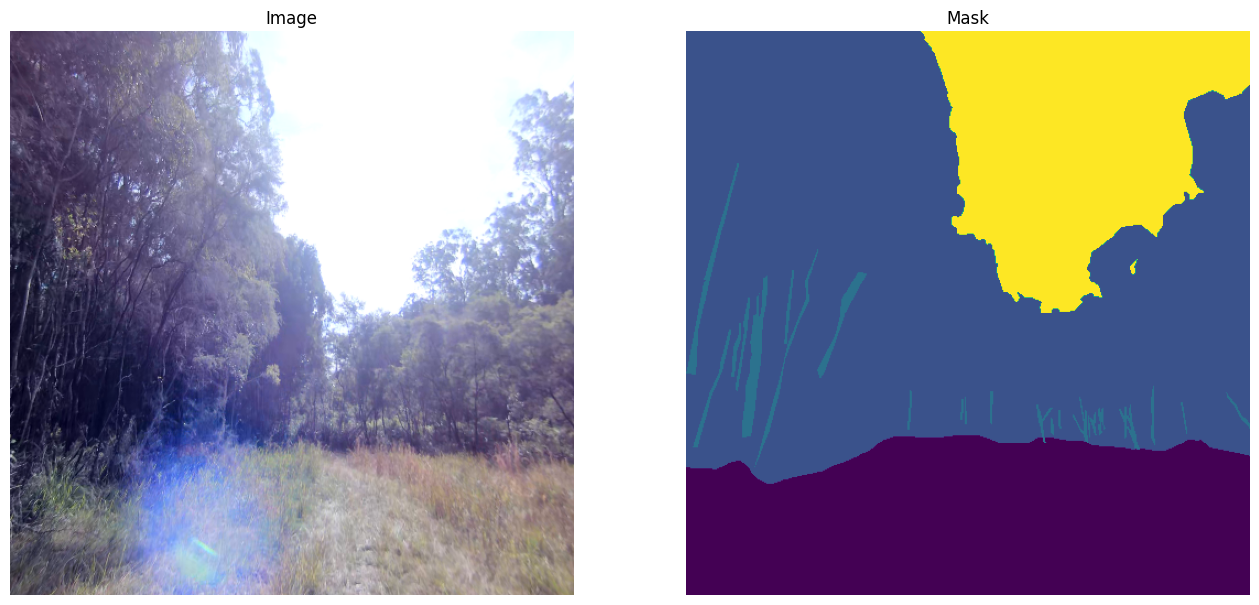

Visualizing Training Data:   0%|          | 0/33 [00:32<?, ?it/s]


In [39]:
if VISUALIZE:
    # Visualization code
    loop = tqdm(train_loader, desc="Visualizing Training Data")
    
    for batch_idx, (images, masks) in enumerate(loop):
        # Move tensors to CPU and convert to NumPy arrays
        images = images.cpu().numpy()
        masks = masks.cpu().numpy()
    
        # Loop over the batch
        for idx in range(images.shape[0]):
            image = images[idx]
            mask = masks[idx]
    
            # Convert image from CHW to HWC format
            image = np.transpose(image, (1, 2, 0))
    
    
            # Squeeze mask if it has a single channel
            if mask.shape[0] == 1:
                mask = np.squeeze(mask, axis=0)
    
            # Display image and mask side by side
            fig, axes = plt.subplots(1, 2, figsize=(16, 9))
    
            axes[0].imshow(image)
            axes[0].set_title('Image')
            axes[0].axis('off')
    
            axes[1].imshow(mask)
            axes[1].set_title('Mask')
            axes[1].axis('off')
    
            plt.show()
    
            break  
    
        break  
    
        loop.set_postfix(batch=batch_idx)

# Train da model

In [10]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.long().to(device=DEVICE)  # long required by cross entropy loss

        # forward
        with t.amp.autocast('cuda'):
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


In [29]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    model.eval()

    with t.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).long()
            preds = model(x)
            preds = t.argmax(preds, dim=1)
            num_correct += (preds == y).sum().item()
            num_pixels += t.numel(preds)

    accuracy = num_correct / num_pixels * 100
    print(f"Got {num_correct}/{num_pixels} with accuracy {accuracy:.2f}%")
    model.train()


def save_predictions_as_imgs(loader, model, folder="/kaggle/working/saved_images/", device="cuda"):
    model.eval()
    # Convert the class_color_map to a tensor
    palette = t.tensor([class_color_map[i] for i in range(len(class_color_map))], dtype=t.uint8).to(device)
    
    with t.no_grad():
        for idx, (x, y) in enumerate(loader):
            x = x.to(device)
            preds = model(x)
            preds = t.argmax(preds, dim=1)  # Shape: [batch_size, height, width]
            
            # Map class indices to colors
            color_preds = palette[preds]  # Shape: [batch_size, height, width, 3]
            
            # Save each image in the batch
            for batch_idx in range(color_preds.shape[0]):
                pred_image = color_preds[batch_idx].cpu().numpy().astype('uint8')
                pred_image_pil = Image.fromarray(pred_image)
                pred_image_pil.save(f"{folder}/pred_{idx}_{batch_idx}.png")
            torchvision.utils.save_image(x.float(), f"/kaggle/working/{idx}.png")
            break
        print("done saving")
    model.train()


In [28]:
!rm -rf /kaggle/working/saved_images/*
!mkdir -p /kaggle/working/saved_images

In [13]:
model = UNet(in_channels=3, out_channels=NUM_CLASSES).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = t.amp.GradScaler(device=DEVICE)

for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        val_loader, model, folder="/kaggle/working/saved_images/", device=DEVICE
    )
print("Done! :)")


100%|██████████| 33/33 [05:33<00:00, 10.10s/it, loss=1.12] 


Got 12854741/38797312 with accuracy 33.13%
done saving


100%|██████████| 33/33 [05:26<00:00,  9.91s/it, loss=0.707]


Got 1775489/38797312 with accuracy 4.58%
done saving


100%|██████████| 33/33 [05:36<00:00, 10.19s/it, loss=0.613]


Got 4715863/38797312 with accuracy 12.16%
done saving
Done! :)


In [30]:
save_predictions_as_imgs(
        test_loader, model, folder="/kaggle/working/saved_images/", device=DEVICE
    )

done saving


In [23]:
check_accuracy(test_loader, model, device=DEVICE)

Got 2566712/19660800 with accuracy 13.05%


# Visualize Test Image

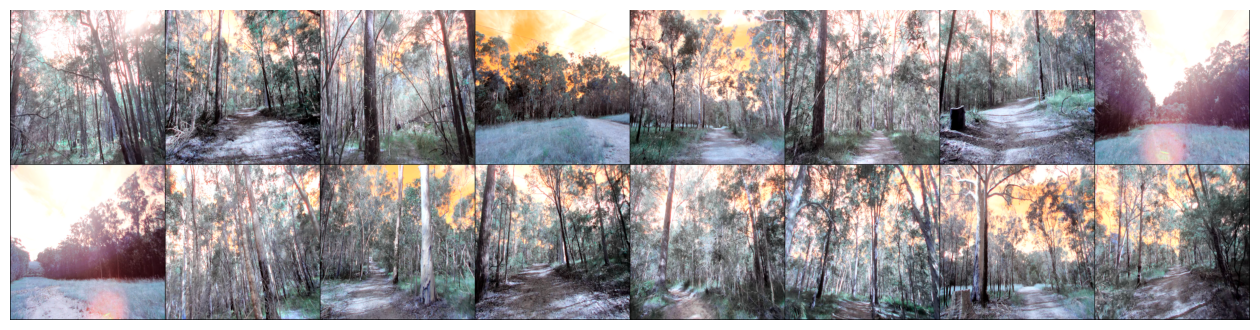

In [46]:
import cv2
from matplotlib import pyplot as plt
plt.figure(figsize=(16, 9))
x_path = "/kaggle/working/0.png"

# Read and display the image
img = cv2.imread(x_path)

plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Visualize Prediction

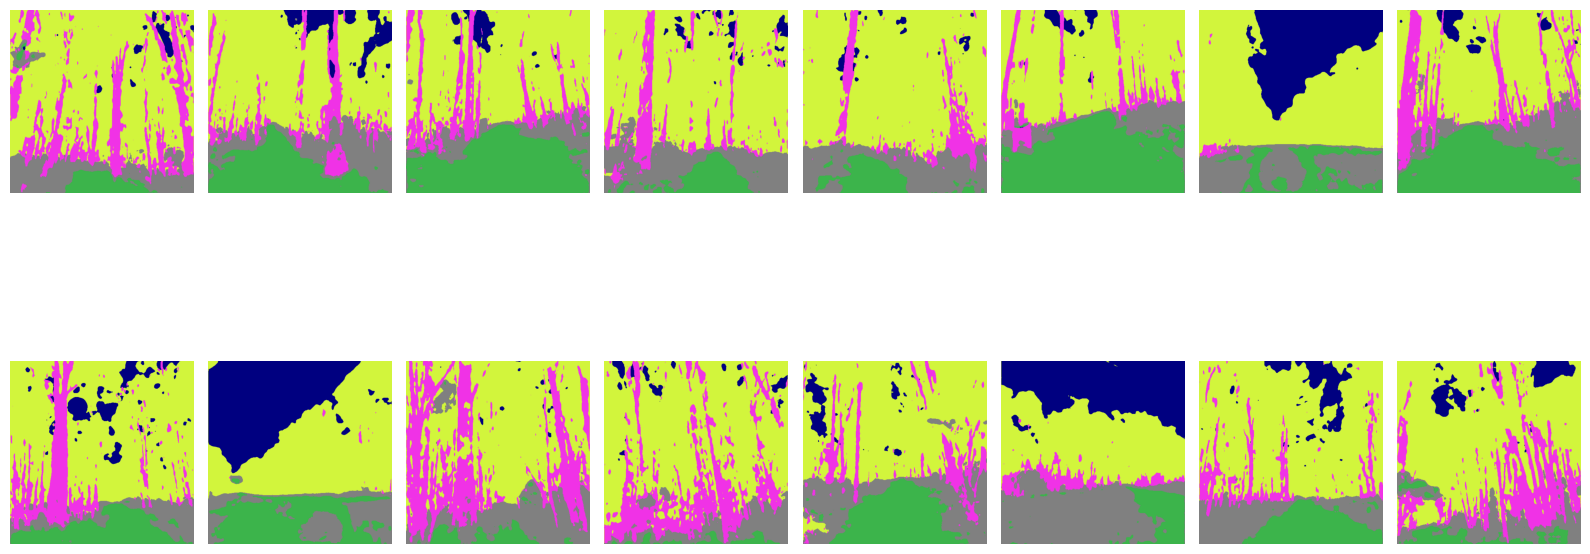

In [42]:
import matplotlib.pyplot as plt
import os
from PIL import Image

saved_images = "/kaggle/working/saved_images/"
image_files = [os.path.join(saved_images, file) for file in os.listdir(saved_images)]

num_images = len(image_files)

fig, axes = plt.subplots(2, 8, figsize=(16, 9))

axes = axes.ravel()

# Loop through images and plot
for i, image_file in enumerate(image_files):
    img = Image.open(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes

# Adjust layout
plt.tight_layout()
plt.show()


# Save Model

In [22]:
    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    t.save(checkpoint, "/kaggle/working/checkpoint.pth")

In [45]:
# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

print(f"Parameters: {total_params}")


Parameters: 31038543
